## Loading and Visualizing the Data


In [1]:
import os

data_dir = "/Users/diegotorrejon/Projects/Other/DL_seminar/data/"

bldg_dir = os.path.join(data_dir, "mass_buildings")
road_dir = os.path.join(data_dir, "mass_roads")


In [ ]:
os.listdir(bldg_dir)


In [2]:
def load_image_paths(path, name):
    # test, train, valid
    ttv = os.listdir(path)
    
    for ttv_typ in ttv:
        # <path>/<test-train-valid>
        typ_path = os.path.join(path, ttv_typ)
        
        # map, sat
        ms = os.listdir(typ_path)
        
        for ms_typ in ms:
            # <path>/<test-train-valid>/<map-sat>
            ms_path = os.path.join(typ_path, ms_typ)
            ms_img_fls = os.listdir(ms_path)
            
            # Only maintain tif/tiff files
            ms_img_fls = [fl for fl in ms_img_fls if fl.endswith(".tiff") or fl.endswith(".tif")]
            
            # Get the scene id
            # 23428915_15.tiff -> 23428915_15
            scene_ids = [fl.replace(".tiff", "").replace(".tif", "") for fl in ms_img_fls]
            
            # Expand to full path
            ms_img_fls = [os.path.join(ms_path, fl) for fl in ms_img_fls]
            
            # Record the map and sat files for each scene
            for fl, scene_id in zip(ms_img_fls, scene_ids):
                images[name][ttv_typ][scene_id][ms_typ] = fl
                

In [3]:
from collections import defaultdict

images = {}
images["buildings"] = {"train": defaultdict(dict), "test": defaultdict(dict), "valid": defaultdict(dict)}
images["roads"] = {"train": defaultdict(dict), "test": defaultdict(dict), "valid": defaultdict(dict)}

load_image_paths(bldg_dir, "buildings")
load_image_paths(road_dir, "roads")



In [4]:
import numpy as np
from PIL import Image

def data_generator(files, size=256, mode="train", batch_size=32):
    while True:
        all_scenes = list(files[mode].keys())
        
        # Randomly choose scenes to use for data
        scene_ids = np.random.choice(all_scenes, size=batch_size, replace=True)
        
        X_fls = [files[mode][scene_id]["sat"] for scene_id in scene_ids]
        Y_fls = [files[mode][scene_id]["map"] for scene_id in scene_ids]
        
        X = np.array([np.asarray(Image.open(fl), dtype=np.float) / 255 for fl in X_fls])
        Y = np.array([np.asarray(Image.open(fl), dtype=np.float)[:,:,:1] / 255 for fl in Y_fls])
        
        n, h, w, c = X.shape
        
        I = np.random.randint(0, h-size, size=batch_size)
        J = np.random.randint(0, w-size, size=batch_size)
        
        X = np.array([x[i:(i+size), j:(j+size)] for x, i, j in zip(X, I, J)])
        Y = np.array([y[i:(i+size), j:(j+size)] for y, i, j in zip(Y, I, J)])
        
        yield X, Y
        
        

In [5]:
train_building_gen = data_generator(images["buildings"])



In [6]:
X, Y = next(train_building_gen)



In [7]:
from matplotlib import pyplot

def show_images(x, y):
    pyplot.figure(figsize=(20,20))
    pyplot.subplot(1,2,1)
    pyplot.imshow(x)
    pyplot.subplot(1,2,2)
    pyplot.imshow(y[:,:,0])
    
    

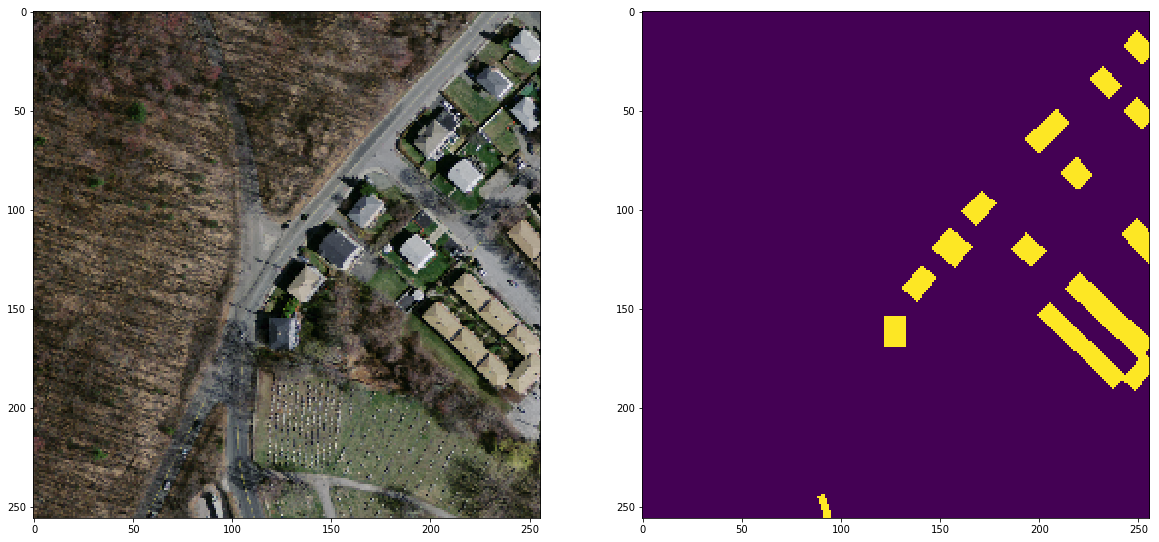

In [8]:
show_images(X[0], Y[0])



In [10]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose


Using TensorFlow backend.


## UNet Architecture

<img src="https://cdn-images-1.medium.com/max/1200/1*dKPBgCdJx6zj3MpED3lcNA.png" alt="Drawing" style="width: 900px;"/>


In [15]:
class UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=8):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = UNet.build_block(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = UNet.build_block(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = UNet.build_block(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = UNet.build_block(x, nfilters=ifilters * 8)
        
        # Bottom block
        x, _ = UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        
        # In: 16x16, Out: 32x32
        x, _ = UNet.build_block(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = UNet.build_block(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = UNet.build_block(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = UNet.build_block(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="binary_crossentropy", optimizer=Adam())
        
    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    

In [16]:
unet = UNet(X[0].shape)


In [17]:
unet._model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 256, 8)  0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 8)  584         activation_20[0][0]              
__________________________________________________________________________________________________
activation

In [18]:
unet._model.fit_generator(train_building_gen, steps_per_epoch=20, epochs=20)


Epoch 1/20
20/20 [==============================] - 140s 7s/step - loss: 0.6850
Epoch 2/20
20/20 [==============================] - 136s 7s/step - loss: 0.6824
Epoch 3/20
20/20 [==============================] - 132s 7s/step - loss: 0.5554
Epoch 4/20
20/20 [==============================] - 38336s 1917s/step - loss: 0.4184
Epoch 5/20
20/20 [==============================] - 24391s 1220s/step - loss: 0.3905
Epoch 6/20
20/20 [==============================] - 134s 7s/step - loss: 0.3625
Epoch 7/20
20/20 [==============================] - 130s 6s/step - loss: 0.3600
Epoch 8/20
20/20 [==============================] - 129s 6s/step - loss: 0.3325
Epoch 9/20
20/20 [==============================] - 129s 6s/step - loss: 0.3199
Epoch 10/20
20/20 [==============================] - 129s 6s/step - loss: 0.2965
Epoch 11/20
20/20 [==============================] - 130s 6s/step - loss: 0.2970
Epoch 12/20
20/20 [==============================] - 131s 7s/step - loss: 0.2950
Epoch 13/20
20/20 [========

In [21]:
Z = unet._model.predict(X)


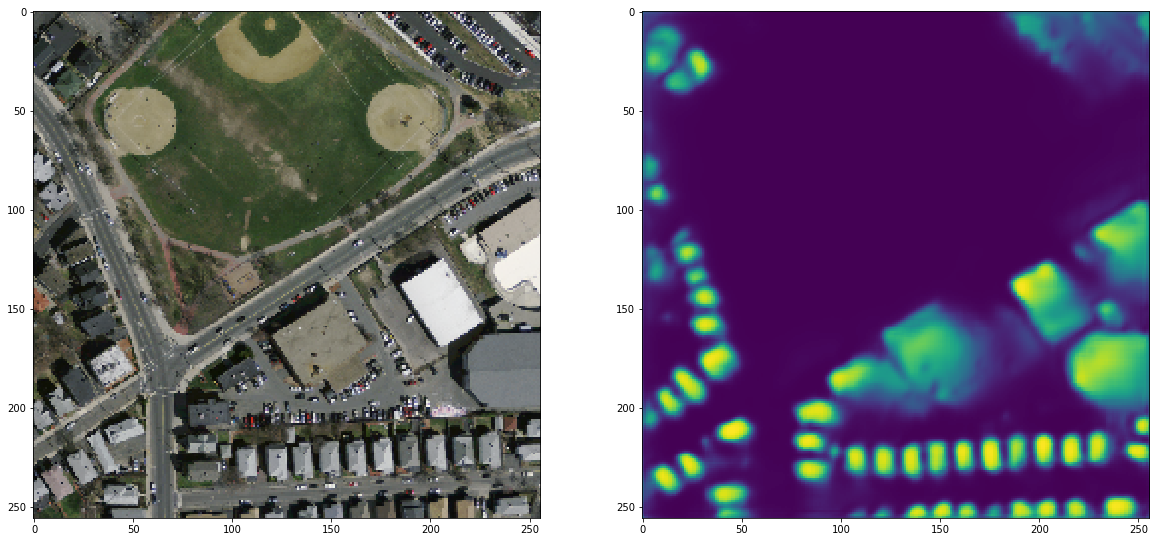

In [22]:
i = 2
show_images(X[i], Z[i])


## Pruning of Parameters in Neural Networks

## Asymmetric Convolution

Recall the Inception v1 module:

<img src="https://cdn-images-1.medium.com/max/1600/1*U_McJnp7Fnif-lw9iIC5Bw.png" alt="Drawing" style="width: 600px;"/>

The Inception v3 module reduced greatly the number of parameters utilized:

<img src="https://cdn-images-1.medium.com/max/1600/0*rRv_N9rLYJnmq6jz.jpg" alt="Drawing" style="width: 500px;"/>

Instead of using standard $\large n \times n$ convolutions, the module uses asymmetric convolutions, i.e., $\large n \times 1$ followed by $\large 1 \times n$. As $\large n$ increases, the reduction of parameters is greater between standard convolutions and asymmetric convolutions. 

Let $\large I$ denote the number of inputs and $\large O$ denote the number of outputs. 

**Standard convolution:** Number of parameters is $\large n \times n \times I \times O$.

**Asymmetric convolution:** Number of parameters is $\large (n + n) \times I \times O$.


## Dilated Convolution

The convolution operator is defined by:

$$ \large  (f * g)[t] = \int_{-\infty}^{\infty} f(t-s) g(s) ds. $$

The discrete convolution operator takes the form:

$$ \large ( F * k)[n] = \sum_{m=-\infty}^{m=\infty} F(n-m) k(m). $$

We now generalize this operator. Let $\large l$ be a dilation factor and let $\large ∗_l$ be defined as

$$ \large ( F *_l k)[n] = \sum_{m=-\infty}^{m=\infty} F(n-l m) k(m). $$

<img src="https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41598-018-24304-3/MediaObjects/41598_2018_24304_Fig2_HTML.jpg" alt="Drawing" style="width: 700px;"/>


Consider applying the filters with exponentially increasing dilation:

$$ \large F_{i+1} = F_i *_{2^i} k_i, \ \text{for} \ i = 0, \ ..., \ n-1,$$ 

where $\large k_i$ denote $\large 3\times3$ kernels.

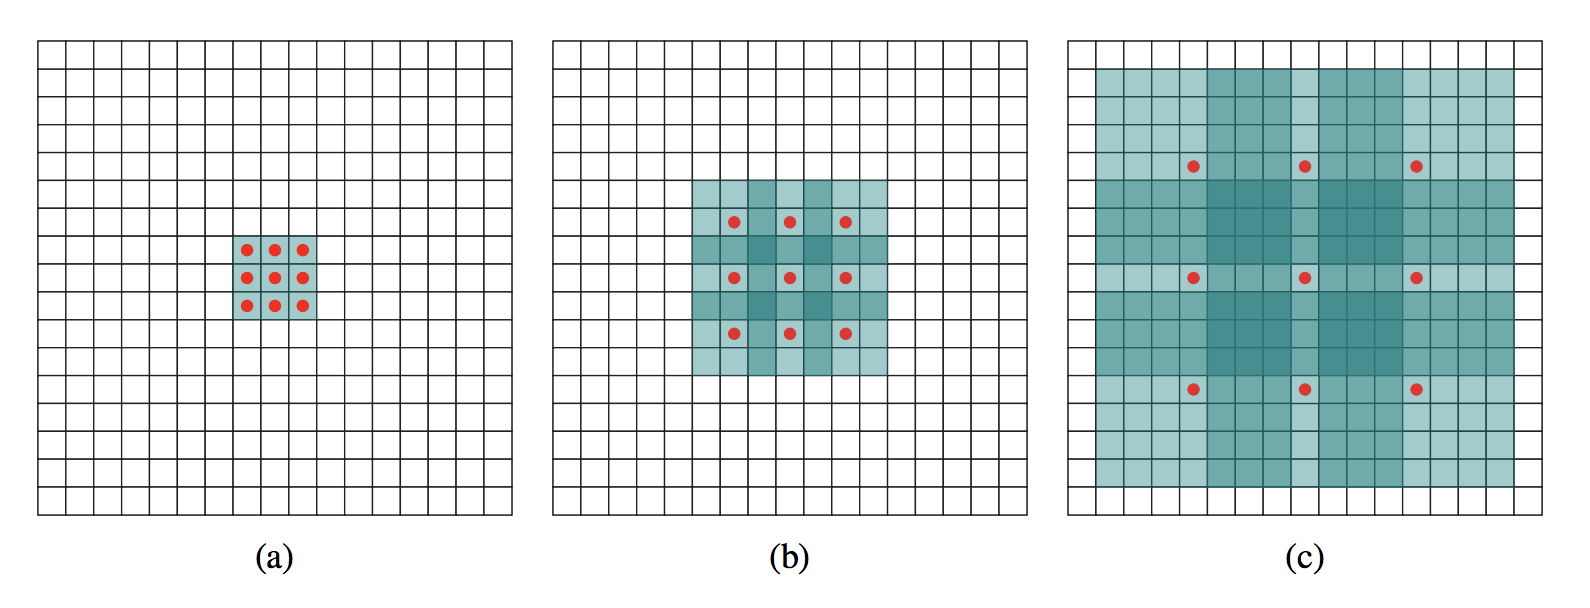



The size of the receptive field increases exponentially $\large (3, 7, 15, ...)$.

**Pro:** Bigger receptive field with fewer kernels than regular convolutions: $\large 3 \ \text{vs.} \ 7$.

**Pro:** Fewer parameters than regular convolutions: $\large 3 \times 3 \times 3\times I \times O \ \text{vs.} \ 7\times 3 \times 3 \times I \times O$.

**Con:** Non-uniform contributions from neighboring pixels.

## Depthwise Convolution

<img src="https://cdn-images-1.medium.com/max/1600/1*VvBTMkVRus6bWOqrK1SlLQ.png" alt="Drawing" style="width: 700px;"/>

**Standard convolution:** Number of parameters is $\large n \times n \times I \times O$.

**Depthwise convolution:** Number of parameters is $ \large n \times n \times I + I \times O.$

**Depthwise + assymetric convolution:** Number of parameters is $\large (n + n) \times I + I\times O.$

## ASPP (Atrous (dilated) Spatial Pyramid Pooling) Module

Inspired by the Inception module and developed to detect small and large features:

<img src="https://zhangbin0917.github.io/2018/06/14/Vortex-Pooling-Improving-Context-Representation-in-Semantic-Segmentation/00.png" alt="Drawing" style="width: 700px;"/>

We use depthwise dilated convolutions to simplify further the number of parameters. We insert the ASPP module at the bottom of the UNet architecture.


In [54]:
## Swap bottom layer with ASPP module using deptwise convolutions

from keras.layers import DepthwiseConv2D

class Dilated_UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=8):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = Dilated_UNet.build_block(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = Dilated_UNet.build_block(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = Dilated_UNet.build_block(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = Dilated_UNet.build_block(x, nfilters=ifilters * 8)
        
        # Bottom block: ASPP Module
        #x, _ = Dilated_UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        x = Dilated_UNet.dilated_block(x, nfilters=ifilters * 16)
        
        # In: 16x16, Out: 32x32
        x, _ = Dilated_UNet.build_block(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = Dilated_UNet.build_block(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = Dilated_UNet.build_block(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = Dilated_UNet.build_block(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="binary_crossentropy", optimizer=Adam())
        
    @staticmethod
    def dilated_block(x, nfilters):
        b0 = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        b0 = Activation("relu")(b0)
        
        b1 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(2,2))(x)
        b1 = Conv2D(nfilters, kernel_size=1, padding='same')(b1)
        b1 = Activation("relu")(b1)

        b2 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(4,4))(x)
        b2 = Conv2D(nfilters, kernel_size=1, padding='same')(b2)
        b2 = Activation("relu")(b2)
        
        b3 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(8,8))(x)
        b3 = Conv2D(nfilters, kernel_size=1, padding='same')(b3)
        b3 = Activation("relu")(b3)
        
        x = Concatenate()([b0, b1, b2, b3])
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)        
        
        return x

    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    
    @staticmethod
    def build_block_depth(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        x = Activation("relu")(x)

        x = DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    

In [55]:
dilated_unet = Dilated_UNet(X[0].shape)
dilated_unet._model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_249 (Conv2D)             (None, 256, 256, 8)  224         input_14[0][0]                   
__________________________________________________________________________________________________
activation_241 (Activation)     (None, 256, 256, 8)  0           conv2d_249[0][0]                 
__________________________________________________________________________________________________
conv2d_250 (Conv2D)             (None, 256, 256, 8)  584         activation_241[0][0]             
__________________________________________________________________________________________________
activation

This produces a $\large 25\%$ reduction in parameters from the original UNet architecture.

In [56]:
## Use depthwise convolutions in all layers

from keras.layers import DepthwiseConv2D

class Dilated_UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=8):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = Dilated_UNet.build_block_depth(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 8)
        
        # Bottom block: ASPP Module
        #x, _ = Dilated_UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        x = Dilated_UNet.dilated_block(x, nfilters=ifilters * 16)
        
        # In: 16x16, Out: 32x32
        x, _ = Dilated_UNet.build_block_depth(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = Dilated_UNet.build_block_depth(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = Dilated_UNet.build_block_depth(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = Dilated_UNet.build_block_depth(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="binary_crossentropy", optimizer=Adam())
        
    @staticmethod
    def dilated_block(x, nfilters):
        b0 = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        b0 = Activation("relu")(b0)
        
        b1 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(2,2))(x)
        b1 = Conv2D(nfilters, kernel_size=1, padding='same')(b1)
        b1 = Activation("relu")(b1)

        b2 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(4,4))(x)
        b2 = Conv2D(nfilters, kernel_size=1, padding='same')(b2)
        b2 = Activation("relu")(b2)
        
        b3 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(8,8))(x)
        b3 = Conv2D(nfilters, kernel_size=1, padding='same')(b3)
        b3 = Activation("relu")(b3)
        
        x = Concatenate()([b0, b1, b2, b3])
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)        
        
        return x

    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    
    @staticmethod
    def build_block_depth(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        x = Activation("relu")(x)

        x = DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    

In [57]:
dilated_unet = Dilated_UNet(X[0].shape)
dilated_unet._model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
depthwise_conv2d_91 (DepthwiseC (None, 256, 256, 3)  30          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_271 (Conv2D)             (None, 256, 256, 8)  32          depthwise_conv2d_91[0][0]        
__________________________________________________________________________________________________
activation_262 (Activation)     (None, 256, 256, 8)  0           conv2d_271[0][0]                 
__________________________________________________________________________________________________
depthwise_

This produces a $\large 72\%$ reduction in parameters from the original UNet architecture.

In [58]:
## Use depthwise convolutions and asymmetric convolutions in all layers

from keras.layers import DepthwiseConv2D

class Dilated_UNet(object):
    def __init__(self, inshape):
        self._inshape = inshape
        self.build_model()
        
    def build_model(self, ifilters=8):
        I = Input(shape=self._inshape)
        
        # In: 256x256, Out: 128x128
        x, s0 = Dilated_UNet.build_block_depth(I, nfilters=ifilters)
        
        # In: 128x128, Out: 64x64
        x, s1 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 2)
        
        # In: 64x64, Out: 32x32
        x, s2 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 4)
        
        # In: 32x32, Out: 16x16
        x, s3 = Dilated_UNet.build_block_depth(x, nfilters=ifilters * 8)
        
        # Bottom block: ASPP Module
        #x, _ = Dilated_UNet.build_block(x, nfilters=ifilters * 16, pooling=False)
        x = Dilated_UNet.dilated_block(x, nfilters=ifilters * 16)
        
        # In: 16x16, Out: 32x32
        x, _ = Dilated_UNet.build_block_depth(x, skip=s3, nfilters=ifilters * 8)
        
        # In: 32x32, Out: 64x64
        x, _ = Dilated_UNet.build_block_depth(x, skip=s2, nfilters=ifilters * 4)
        
        # In: 64x64, Out: 128x128
        x, _ = Dilated_UNet.build_block_depth(x, skip=s1, nfilters=ifilters * 2)
        
        # In: 128x128, Out: 256x256
        x, _ = Dilated_UNet.build_block_depth(x, skip=s0, nfilters=ifilters)
        
        # Output Layer
        x = Conv2D(1, kernel_size=3, padding="same")(x)
        x = Activation("sigmoid")(x)
        
        # Build the model using I as input and x as output
        self._model = Model(inputs=I, outputs=x)
        
        # Compile the model using binary cross-entropy loss and the Adam optimizer
        self._model.compile(loss="binary_crossentropy", optimizer=Adam())
        
    @staticmethod
    def dilated_block(x, nfilters):
        b0 = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        b0 = Activation("relu")(b0)
        
        b1 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(2,2))(x)
        b1 = Conv2D(nfilters, kernel_size=1, padding='same')(b1)
        b1 = Activation("relu")(b1)

        b2 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(4,4))(x)
        b2 = Conv2D(nfilters, kernel_size=1, padding='same')(b2)
        b2 = Activation("relu")(b2)
        
        b3 = DepthwiseConv2D(kernel_size=(3,3), padding='same', dilation_rate=(8,8))(x)
        b3 = Conv2D(nfilters, kernel_size=1, padding='same')(b3)
        b3 = Activation("relu")(b3)
        
        x = Concatenate()([b0, b1, b2, b3])
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)        
        
        return x

    
    @staticmethod
    def build_block(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        
        x = Conv2D(nfilters, kernel_size=3, padding="same")(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    
    @staticmethod
    def build_block_depth(x, skip=None, nfilters=32, pooling=True):
        if skip is not None:
            x = UpSampling2D()(x)
            x = Concatenate()([x, skip])
            
        x = DepthwiseConv2D(kernel_size=(5,1), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        x = Activation("relu")(x)

        x = DepthwiseConv2D(kernel_size=(1,5), padding='same')(x)
        x = Conv2D(nfilters, kernel_size=1, padding='same')(x)
        s = Activation("relu")(x)
        
        if skip is None and pooling:
            x = MaxPool2D()(s)
        else:
            x = s
            
        # Output and skip connection
        return x, s
    

In [59]:
dilated_unet = Dilated_UNet(X[0].shape)
dilated_unet._model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
depthwise_conv2d_110 (Depthwise (None, 256, 256, 3)  18          input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_293 (Conv2D)             (None, 256, 256, 8)  32          depthwise_conv2d_110[0][0]       
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 256, 256, 8)  0           conv2d_293[0][0]                 
__________________________________________________________________________________________________
depthwise_

This produces a $\large 73\%$ reduction in parameters from the original UNet architecture.